# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [13]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt


import statsmodels.api as sm
from statsmodels.tsa.filters.filtertools import convolution_filter
import statsmodels.graphics.tsaplots as tsplots
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

data = pd.read_csv('data/vehicles.csv')
data.sample(5)

#dropping Nan values rows
data = data.dropna()
#dropping vin as its not used in determining car price
#dropping region also to keep data evaluation simple.
data = data.drop(columns=['VIN','region'])
data.sample(5)



,id,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
99142,7312777280,11900,2012.0,volkswagen,tiguan,excellent,4 cylinders,gas,69292.0,clean,automatic,fwd,full-size,SUV,silver,fl
370747,7315263026,8995,2012.0,cadillac,srx luxury,excellent,6 cylinders,gas,116500.0,rebuilt,automatic,fwd,full-size,SUV,grey,tx
49060,7315295947,7950,2013.0,mazda,mazda3,excellent,4 cylinders,gas,110475.0,clean,automatic,fwd,compact,sedan,blue,ca
117918,7314819952,1,2019.0,ram,3500,excellent,6 cylinders,gas,48785.0,clean,other,4wd,full-size,truck,white,fl
275047,7316800578,4995,2002.0,gmc,sierra 3500,fair,8 cylinders,diesel,198727.0,clean,automatic,rwd,full-size,truck,blue,ny


In [14]:
#marking labels for odomoter and condition fields
def categorize_odometer(odometer):
    if odometer < 100000:
        return 'Low'
    elif 100000 <= odometer <= 300000:
        return 'Medium'
    else:
        return 'High'

def categorize_condition(condition):
    if condition == 'salvage':
        return 1
    elif condition == 'fair':
        return 2
    elif condition == 'good':
        return 3    
    elif condition == 'excellent':
        return 4 
    elif condition == 'like new':
        return 5 
    elif condition == 'new':
        return 6

data['condition_value']= data['condition'].apply(categorize_condition)
data['categorize_milage']= data['odometer'].apply(categorize_odometer)
data = data.drop(columns=['odometer','condition'])
data.sample(5)

,id,price,year,manufacturer,model,cylinders,fuel,title_status,transmission,drive,size,type,paint_color,state,condition_value,categorize_milage
52914,7316070346,16500,2017.0,honda,crv,4 cylinders,gas,salvage,automatic,4wd,full-size,SUV,grey,ca,4,Low
171425,7312163946,13780,2014.0,honda,civic lx,4 cylinders,gas,clean,automatic,fwd,full-size,sedan,grey,ky,5,Low
373252,7304842898,11200,2016.0,mazda,mazda3,4 cylinders,gas,clean,automatic,fwd,mid-size,sedan,white,tx,3,Low
170113,7304351878,24900,2019.0,nissan,pathfinder,6 cylinders,gas,clean,automatic,4wd,full-size,SUV,black,ks,4,Low
290395,7311869060,0,2009.0,ford,f-150,8 cylinders,gas,clean,automatic,4wd,mid-size,truck,black,oh,4,Low


In [15]:
#evaluating data per state


<Axes: title={'center': 'total_car_count_distribution_per_state'}, xlabel='state', ylabel='count'>

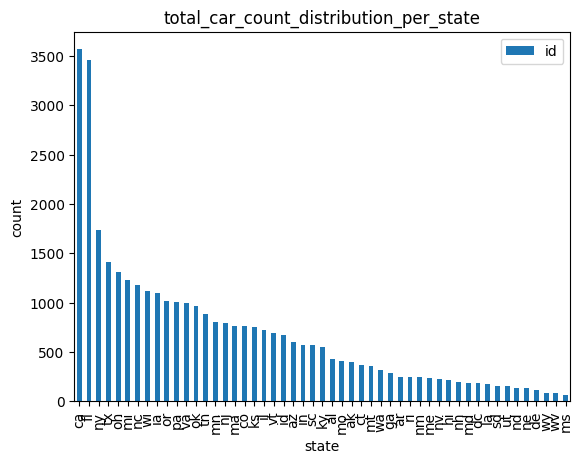

In [16]:
car_count_state = data.groupby(by=['state']).count().reset_index(['state']).sort_values(['price'], ascending=False)[['id','state']]
car_count_state_df = pd.DataFrame(car_count_state, columns=['id','state'])
car_count_state_df.plot(kind='bar',x='state',y='id',xlabel='state',ylabel='count',title='total_car_count_distribution_per_state')

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

<Axes: title={'center': 'total_price_distribution_per_state'}, xlabel='state', ylabel='price'>

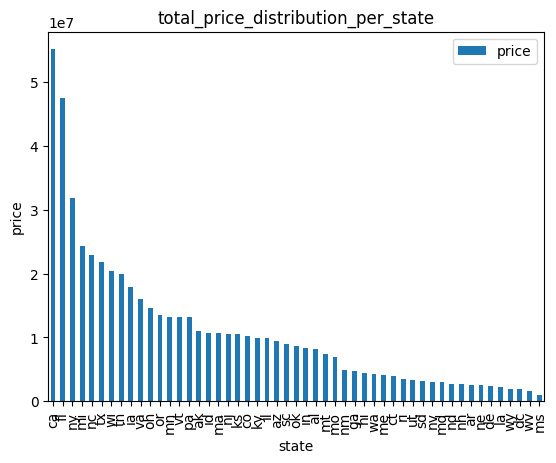

In [17]:

price_state = data.groupby(by=['state']).sum('price').reset_index(['state']).sort_values(['price'], ascending=False)[['price','state']]
price_state_df = pd.DataFrame(price_state, columns=['price','state'])
price_state_df.plot(kind='bar',x='state',y='price',xlabel='state',ylabel='price',title='total_price_distribution_per_state')


<Axes: title={'center': 'total_mean_price_distribution_per_state'}, xlabel='state', ylabel='price'>

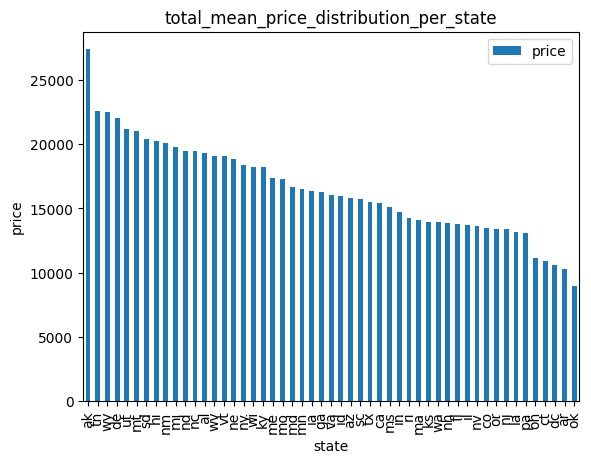

In [18]:


price_mean_state = data.groupby(by=['state']).mean('price').reset_index('state').sort_values('price',ascending=False)
price_mean_state_df = pd.DataFrame(price_mean_state, columns=['price','state'])
price_mean_state_df.plot(kind='bar',x='state',y='price',xlabel='state',ylabel='price',title='total_mean_price_distribution_per_state')


<Axes: title={'center': 'total_distribution_per_manufacturer'}, xlabel='manufacturer', ylabel='count'>

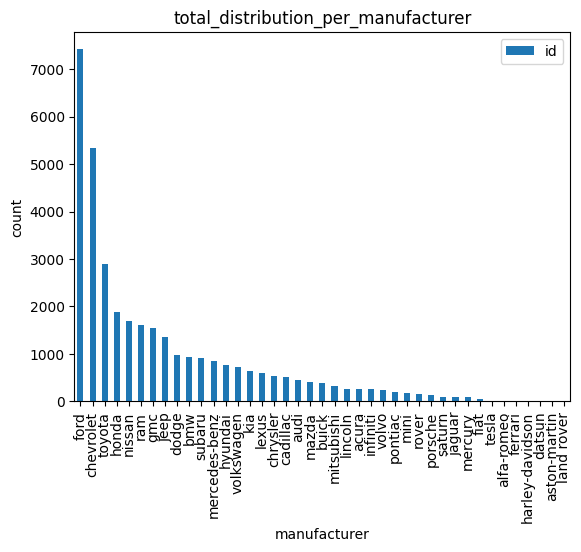

In [19]:
#data analysis per manufacture

man_dist = data.groupby(by=['manufacturer']).count().reset_index('manufacturer').sort_values('id',ascending=False)
man_dist_df = pd.DataFrame(man_dist, columns=['id','manufacturer'])
man_dist_df.plot(kind='bar',x='manufacturer',y='id',xlabel='manufacturer',ylabel='count',title='total_distribution_per_manufacturer')

<Axes: title={'center': 'distribution_per_color'}, xlabel='car color', ylabel='count_per_color'>

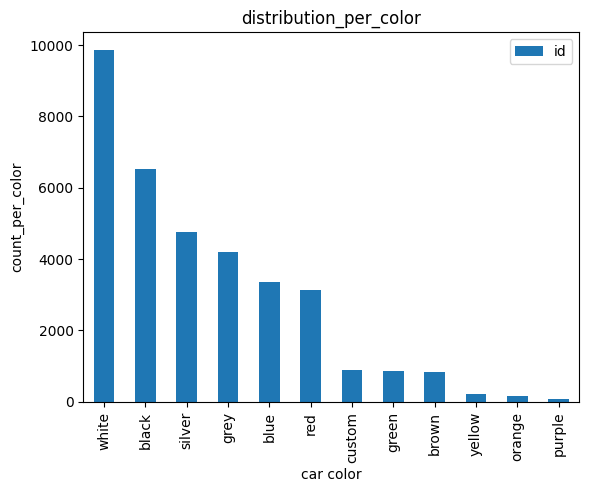

In [20]:
color_dist = data.groupby(by=['paint_color']).count().reset_index('paint_color').sort_values('id',ascending=False)
color_dist_df = pd.DataFrame(color_dist, columns=['id','paint_color'])
color_dist_df.plot(kind='bar',x='paint_color',y='id',xlabel='car color',ylabel='count_per_color',title='distribution_per_color')

<Axes: xlabel='year', ylabel='price'>

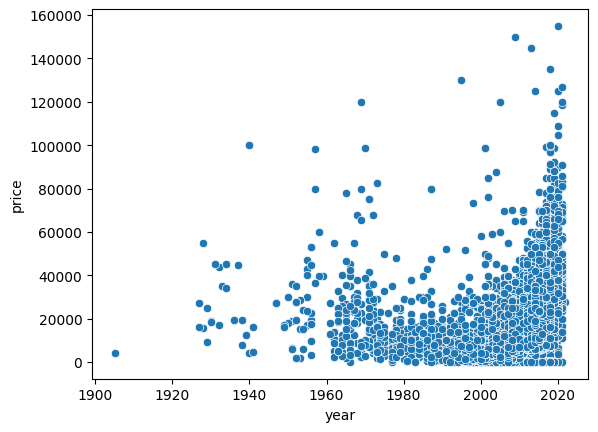

In [21]:
sns.scatterplot(data,x='year',y='price')

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [22]:

# model definition- A linear model and ridge model pipelines are defined here.
# 

ridge_model = Pipeline([
    ("poly", PolynomialFeatures()),
    ("scale", StandardScaler()),
    ("regression", Ridge())
])

lin_model = Pipeline([
    ("poly", PolynomialFeatures()),
    ("scale", StandardScaler()),
    ("regression", LinearRegression())
])

data.dropna()

# using label encoder to process non numeric features in the data set
from sklearn.preprocessing import LabelEncoder
Car_Name_le = LabelEncoder()
data['Car_Name'] = Car_Name_le.fit_transform(data['manufacturer'])
Fuel_Type_le = LabelEncoder()
data['Fuel_Type'] = Fuel_Type_le.fit_transform(data['fuel'])
Selling_type_le = LabelEncoder()
data['Selling_type'] = Selling_type_le.fit_transform(data['type'])
Transmission_le = LabelEncoder()
data['Transmission'] = Transmission_le.fit_transform(data['transmission'])

##Split the data into X AND Y
input_data = data[["Car_Name", "Fuel_Type", "Selling_type", "Transmission"]]
output_data = data[["price"]]

#setting up test and train dataset, test = 70% dataset and remaining 30% would be dev test set

X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.3, random_state=42)
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (24407, 4) (24407, 1)
Testing set shape: (10461, 4) (10461, 1)


In [23]:

#Ridge regression with grid search CV to determine best alpha for the model

#parameters to try, alpha, fixing polynomial degree==3
param_to_try = {'regression__alpha' : 10**np.linspace(-5, 4, num=10), 'poly__degree': [3]}

model_finder = GridSearchCV(estimator=ridge_model, param_grid= param_to_try, scoring="neg_mean_squared_error")
model_finder.fit(X_train,y_train)
model_finder
best_model = model_finder.best_estimator_
best_model
preds = best_model.predict(X_test)
mse = mean_squared_error(y_test, preds)
print('Ridge model MSE', mse)
print('input data columns' ,best_model.named_steps['poly'].get_feature_names_out())
print('best model coefficients' , best_model.named_steps['regression'].coef_)

model_finder.cv_results_

#coef analyis
#input data columns and best model coefficients list indicate wieght of the feature in the fitted 3 degree polynomial equation

#cv result analysis-
#'rank_test_score': array([ 6,  5,  4,  3,  2,  1,  7,  8,  9, 10], dtype=int32)}
# best model is 6th model which is with alpha==1
#'params': [{'poly__degree': 3, 'regression__alpha': 1e-05},
#  {'poly__degree': 3, 'regression__alpha': 0.0001},
#  {'poly__degree': 3, 'regression__alpha': 0.001},
#  {'poly__degree': 3, 'regression__alpha': 0.01},
#  {'poly__degree': 3, 'regression__alpha': 0.1},
#  {'poly__degree': 3, 'regression__alpha': 1.0}, <--
#  {'poly__degree': 3, 'regression__alpha': 10.0},
#  {'poly__degree': 3, 'regression__alpha': 100.0},
#  {'poly__degree': 3, 'regression__alpha': 1000.0},
#  {'poly__degree': 3, 'regression__alpha': 10000.0}],

Ridge model MSE 153406714.98268923
input data columns ['1' 'Car_Name' 'Fuel_Type' 'Selling_type' 'Transmission' 'Car_Name^2'
 'Car_Name Fuel_Type' 'Car_Name Selling_type' 'Car_Name Transmission'
 'Fuel_Type^2' 'Fuel_Type Selling_type' 'Fuel_Type Transmission'
 'Selling_type^2' 'Selling_type Transmission' 'Transmission^2'
 'Car_Name^3' 'Car_Name^2 Fuel_Type' 'Car_Name^2 Selling_type'
 'Car_Name^2 Transmission' 'Car_Name Fuel_Type^2'
 'Car_Name Fuel_Type Selling_type' 'Car_Name Fuel_Type Transmission'
 'Car_Name Selling_type^2' 'Car_Name Selling_type Transmission'
 'Car_Name Transmission^2' 'Fuel_Type^3' 'Fuel_Type^2 Selling_type'
 'Fuel_Type^2 Transmission' 'Fuel_Type Selling_type^2'
 'Fuel_Type Selling_type Transmission' 'Fuel_Type Transmission^2'
 'Selling_type^3' 'Selling_type^2 Transmission'
 'Selling_type Transmission^2' 'Transmission^3']
best model coefficients [[     0.           8675.36785616  -2874.38953664   8746.27155411
   -2668.0051904  -11500.16931674  -8060.39767574   320

{'mean_fit_time': array([0.01542664, 0.01844678, 0.01557312, 0.01659784, 0.01561379,
        0.01493268, 0.01639647, 0.01599631, 0.01576037, 0.01531706]),
 'std_fit_time': array([0.00308807, 0.00833985, 0.00351807, 0.00598112, 0.00395673,
        0.00213314, 0.00179052, 0.00210031, 0.00426751, 0.00191576]),
 'mean_score_time': array([0.00385966, 0.00293784, 0.00279741, 0.00205798, 0.00533018,
        0.00296884, 0.00430846, 0.00448575, 0.00270176, 0.00519013]),
 'std_score_time': array([0.00293939, 0.00111521, 0.00085051, 0.00041053, 0.00306705,
        0.00136103, 0.00300214, 0.00355881, 0.00078446, 0.00309361]),
 'param_poly__degree': masked_array(data=[3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value=999999),
 'param_regression__alpha': masked_array(data=[1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0,
                    1000.0, 10000.0],
              mask=[False, Fal

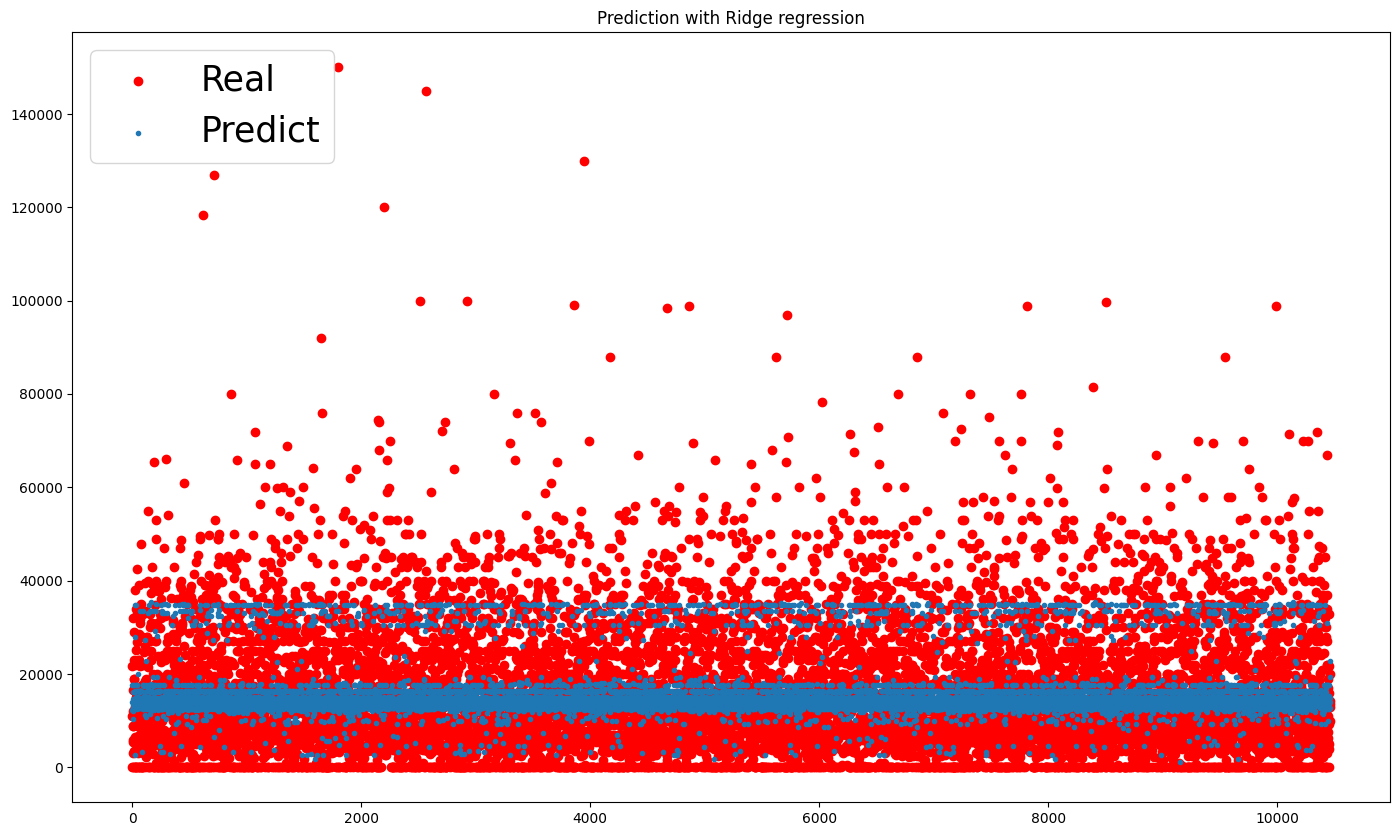

In [24]:


#before grahp indicate real values for dev test prices and price calulated with the modelling
# in the 'real' data there seems to be outliers price > 60000 but for other data points modelling value is close to real value.
# This also represent model is not over fitted.

fig = plt.figure(figsize=(17, 10))
plt.title(f"Prediction with Ridge regression")
plt.scatter(range(X_test.shape[0]), y_test, color='red', label='Real')
plt.scatter(range(X_test.shape[0]), preds, marker='.', label='Predict')
plt.legend(loc=2, prop={'size': 25})
plt.show()

In [25]:
# data modeling using linear regression
lin_model.fit(X_train, y_train)
print('input data columns' ,lin_model.named_steps['poly'].get_feature_names_out())

print(lin_model.named_steps['regression'].coef_)
preds = lin_model.predict(X_test)
mse = mean_squared_error(y_test, preds)
print('MSE ', mse)

input data columns ['1' 'Car_Name' 'Fuel_Type' 'Selling_type' 'Transmission' 'Car_Name^2'
 'Car_Name Fuel_Type' 'Car_Name Selling_type' 'Car_Name Transmission'
 'Fuel_Type^2' 'Fuel_Type Selling_type' 'Fuel_Type Transmission'
 'Selling_type^2' 'Selling_type Transmission' 'Transmission^2']
[[    0.           -94.71425968 -5131.58795852  1337.63162369
   1638.03868082  -279.390858     307.72761776  -968.21368936
     39.43173218  2367.19625504 -3859.14416755   -42.63395487
   3628.5037805  -1513.00609583 -1434.99968794]]
MSE  154685695.04151982


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

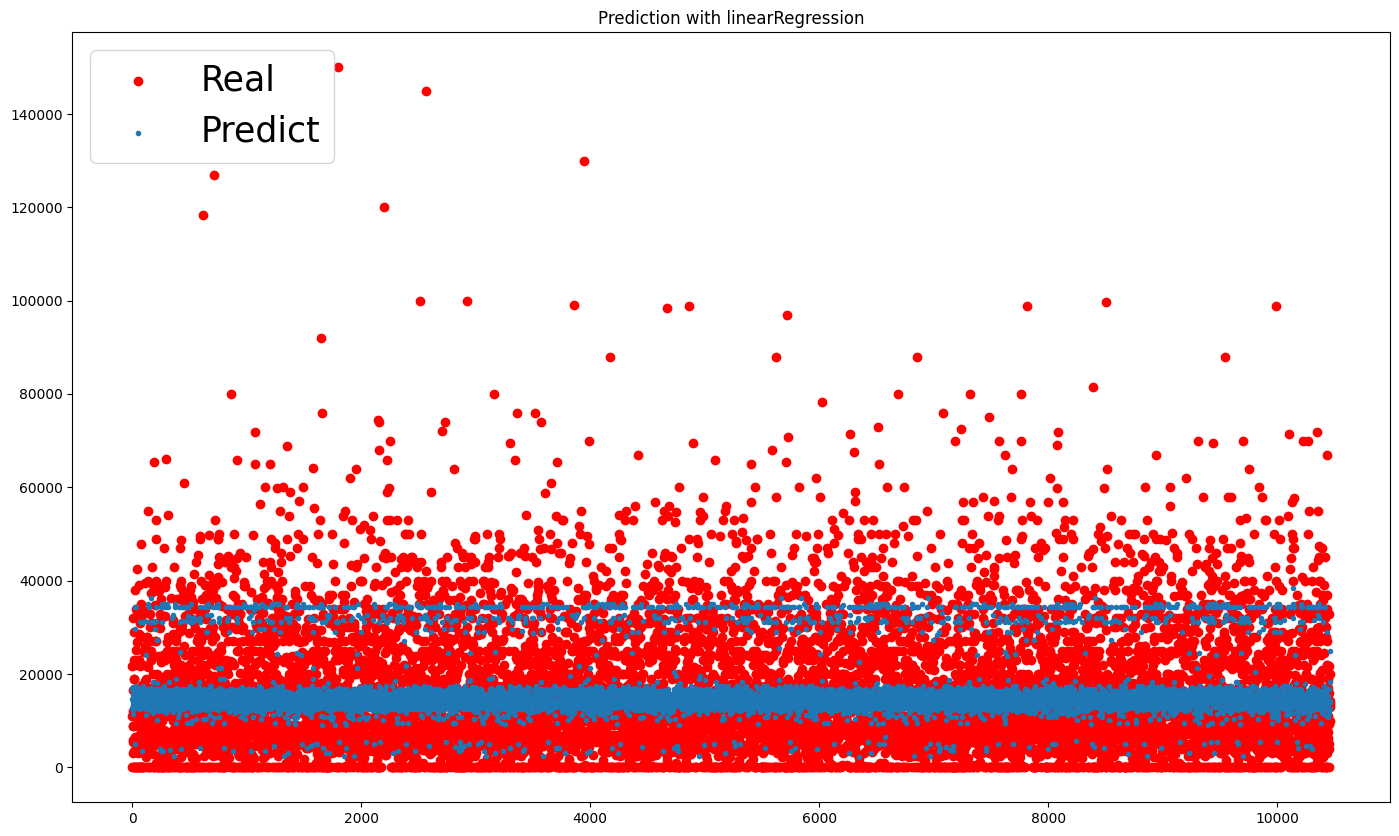

In [26]:
fig = plt.figure(figsize=(17, 10))
plt.title(f"Prediction with linearRegression")
plt.scatter(range(X_test.shape[0]), y_test, color='red', label='Real')
plt.scatter(range(X_test.shape[0]), preds, marker='.', label='Predict')
plt.legend(loc=2, prop={'size': 25})
plt.show()

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.